#### En tant que data analyst freelance chez BottleNeck, notre première mission se décompose en trois parties:

 - Rapprochement d'un export contenant les références produit, le prix de vente et l'état de stock, avec un export contenant les informations des produits vendus en ligne.
 - Calcul du chiffre d'affaires par produit et du chiffre d'affaires total réalisé en ligne.
 - Analyse spécifique sur les prix des produits.

## Sommaire

* [Étapes préliminaires](#chapter1)
    * [Importation des librairies](#section_1_1)
    * [Importation des données](#section_1_2)
    * [Nettoyage des données](#section_1_3)
        * [erp](#section_1_3_1)
        * [liaison](#section_1_3_2)
        * [web](#section_1_3_3)
* [Jointure entre les dataframes df_erp_liaison et web_product](#chapter2)
* [Calcul du chiffre d'affaires par produit et du chiffre d'affaires total](#chapter3)
    * [Chiffre d'affaires par produit](#section_3_1)
    * [Chiffre d'affaires total](#section_3_2)
* [Analyse des prix des produits](#chapter4)
    * [Méthode intervalle interquartile](#section_4_1)
    * [Méthode z-score](#section_4_2)
* [Conclusion](#chapter5)

# Étapes préliminaires <a class="anchor" id="chapter1"></a>

## Importation des librairies <a class="anchor" id="section_1_1"></a>

In [1]:
# Manipulation des données
import pandas as pd

# Visualization des données
import matplotlib.pyplot as plt
%matplotlib inline 

## Importation des données <a class="anchor" id="section_1_2"></a>

In [2]:
erp = pd.read_csv("C:/Users/jorda/P5/Data/erp.csv", sep = ';', decimal = ',')
web = pd.read_csv("C:/Users/jorda/P5/Data/web.csv", sep = ';')
liaison = pd.read_csv("C:/Users/jorda/P5/Data/liaison.csv", sep = ';')

## Nettoyage des données <a class="anchor" id="section_1_3"></a>

### erp <a class="anchor" id="section_1_3_1"></a>

In [3]:
erp.head()

,product_id,onsale_web,price,stock_quantity,stock_status
0,3847,1,24.2,0,outofstock
1,3849,1,34.3,0,outofstock
2,3850,1,20.8,0,outofstock
3,4032,1,14.1,0,outofstock
4,4039,1,46.0,0,outofstock


In [4]:
# On regarde s'il y a des doublons au niveau des lignes
print("Il y a", erp.duplicated().sum(), "lignes en doubles")
print(" ")

# On affiche le compte des valeurs manquantes pour chaque colonne
print("Valeurs manquantes:")
erp.isna().sum()

Il y a 0 lignes en doubles
 
Valeurs manquantes:


product_id        0
onsale_web        0
price             0
stock_quantity    0
stock_status      0
dtype: int64

In [5]:
# On affiche le nombre de lignes et de colonnes
print("erp est composé de", erp.shape[0], "lignes et", erp.shape[1], "colonnes.")
print(" ")

# On affiche le compte des valeurs uniques dans chaque colonne
print("Nombre de valeurs uniques par colonne:")
erp.nunique()

erp est composé de 825 lignes et 5 colonnes.
 
Nombre de valeurs uniques par colonne:


product_id        825
onsale_web          2
price             381
stock_quantity    128
stock_status        2
dtype: int64

Dans ce dataframe il n'y a pas de doublons ni de données manquantes.  
Au niveau de 'product_id' il n'y a pas de valeurs manquantes. La colonne contient 825 valeurs distinctes, soit le nombre de lignes de erp, l'unicité de la clé est respectée. On peut donc considérer 'product_id' comme la clé primaire du dataframe erp.

### liaison <a class="anchor" id="section_1_3_2"></a>

In [6]:
liaison.head()

,product_id,id_web
0,3847,15298
1,3849,15296
2,3850,15300
3,4032,19814
4,4039,19815


In [7]:
# On affiche le nombre de lignes et de colonnes
print("liaison est composé de", liaison.shape[0], "lignes et", liaison.shape[1], "colonnes.")
print(" ")

# On regarde s'il y a des doublons au niveau des lignes
print("Il y a", liaison.duplicated().sum(), "lignes en doubles")
print(" ")

# On affiche le compte des valeurs uniques dans chaque colonne
print("Nombre de valeurs uniques par colonne:")
liaison.nunique()

liaison est composé de 825 lignes et 2 colonnes.
 
Il y a 0 lignes en doubles
 
Nombre de valeurs uniques par colonne:


product_id    825
id_web        734
dtype: int64

In [8]:
# On affiche le compte des valeurs manquantes pour chaque colonne
print("Valeurs manquantes:")
liaison.isna().sum()

Valeurs manquantes:


product_id     0
id_web        91
dtype: int64

La colonne 'product_id' du dataframe liaison ne contient aucune valeur manquante et l'unicité de la clé est respectée. Dans la colonne 'id_web' on a 734 valeurs uniques sur 825 lignes, les 91 autres valeurs sont en réalité des valeurs manquantes (NaN). Ces 91 produits identifiés par la colonne 'product_id' n'ont pas de 'id_web' permettant de référencer le dataframe web.  

Parmi ces 91 produits, on souhaite savoir s'ils sont censés être vendu ou non sur le site web. Pour cela, on réalise une jointure entre les dataframe erp et liaison.

In [9]:
# On réalise une jointure entre erp et liaison(qui contient les 91 valeurs manquantes dans la colonne 'id_web')
df_erp_liaison = pd.merge(erp, liaison, how='inner', on='product_id')

# Et on regarde si parmi les lignes qui ont une valeur manquante dans 'id_web' il y en a avec la valeur 1 dans 'onsale_web'
mask = (df_erp_liaison['id_web'].isnull()) & (df_erp_liaison['onsale_web'] == 1)
df_erp_liaison.loc[mask]

,product_id,onsale_web,price,stock_quantity,stock_status,id_web
242,4594,1,144.0,0,outofstock,NaN
486,5070,1,84.7,0,outofstock,NaN
487,5075,1,43.3,0,outofstock,NaN


Parmi ces 91 produits il y en a 3, avec les identifiants 4594, 5070 et 5075, qui devraient être vendus sur le site ('onsale_web'= 1) mais qui n'ont pas de 'id_web' qui permette de référencer la clé primaire du dataframe web.  
Ceci pourrait être dû  à une erreur dans le renseignement de la colonne 'onsale_web' ou au fait que ces produits n'ont pas encore été mis en vente sur le site.

In [10]:
# On regarde les lignes qui ont une valeur manquante dans 'id_web' avec la valeur 0 dans 'onsale_web'
mask = (df_erp_liaison['id_web'].isnull()) & (df_erp_liaison['onsale_web'] == 0)
df_erp_liaison.loc[mask]

,product_id,onsale_web,price,stock_quantity,stock_status,id_web
19,4055,0,86.1,0,outofstock,NaN
49,4090,0,73.0,0,outofstock,NaN
50,4092,0,47.0,0,outofstock,NaN
119,4195,0,14.1,0,outofstock,NaN
131,4209,0,73.5,0,outofstock,NaN
...,...,...,...,...,...,...
817,7196,0,31.0,55,instock,NaN
818,7200,0,31.0,6,instock,NaN
819,7201,0,31.0,18,instock,NaN
820,7203,0,45.0,30,instock,NaN


Pour le reste des produits qui n'ont pas de id_web, on a bien un 0 dans la colonne 'onsale_web' signifiant qu'ils ne sont pas vendus sur le site.  

On s'intéresse maintenant aux lignes qui ont un id_web

In [11]:
# On regarde les lignes avec un 'id_web' et la valeur 0 dans 'onsale_web'
mask = (~ df_erp_liaison['id_web'].isna()) & (df_erp_liaison['onsale_web'] == 0)
df_erp_liaison.loc[mask]

,product_id,onsale_web,price,stock_quantity,stock_status,id_web
193,4289,0,22.8,0,outofstock,13771
236,4568,0,21.5,0,outofstock,15065
241,4584,0,32.3,0,outofstock,14785
355,4741,0,12.4,0,outofstock,12601
391,4864,0,8.3,0,outofstock,15154
394,4869,0,17.2,0,outofstock,14360
424,4921,0,13.8,0,outofstock,15608
425,4922,0,21.5,0,outofstock,15586
470,5018,0,15.4,0,outofstock,15272
473,5021,0,17.1,0,outofstock,15630


Nous avons 20 produits qui ont un id_web mais qui ont 0 dans 'onsale_web'. Ils ne doivent pas être vendus sur le site d'après les renseignements de la colonne 'onsale_web', nous regarderons si ces lignes ont trouvé une correspondance lors de la jointure avec le dataframe web.

In [12]:
# On regarde les lignes avec un 'id_web' et la valeur 1 dans 'onsale_web'
mask = (~ df_erp_liaison['id_web'].isna()) & (df_erp_liaison['onsale_web'] == 1)
df_erp_liaison.loc[mask].shape

(714, 6)

Le 714 autres produits avec un id_web ont bien la valeur 1 dans 'onsale_web'.  

On décide de ne garder que les lignes qui ont un id_web, les autres ne trouveront pas de correspondance lors de la jointure avec le dataframe web.

In [13]:
# On ne garde que les lignes sans valeurs manquantes dans 'id_web'
mask = ~ df_erp_liaison['id_web'].isnull()
df_erp_liaison = df_erp_liaison.loc[mask]

# On affiche le nombre de lignes et de colonnes
print("df_erp_liaison est composé de", df_erp_liaison.shape[0], "lignes et", df_erp_liaison.shape[1], "colonnes.")

df_erp_liaison est composé de 734 lignes et 6 colonnes.


### web <a class="anchor" id="section_1_3_3"></a>

In [14]:
web.head(3)

,sku,virtual,downloadable,rating_count,average_rating,total_sales,tax_status,tax_class,post_author,post_date,...,post_name,post_modified,post_modified_gmt,post_content_filtered,post_parent,guid,menu_order,post_type,post_mime_type,comment_count
0,bon-cadeau-25-euros,0,0,0,0.0,10.0,taxable,NaN,1.0,2018-06-01 13:53:46,...,bon-cadeau-de-25-euros,2018-06-01 14:13:57,2018-06-01 12:13:57,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
1,15298,0,0,0,0.0,6.0,taxable,NaN,2.0,2018-02-08 12:58:52,...,pierre-jean-villa-saint-joseph-preface-2018,2019-12-30 09:30:29,2019-12-30 08:30:29,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
2,15296,0,0,0,0.0,0.0,taxable,NaN,2.0,2018-02-08 13:49:41,...,pierre-jean-villa-saint-joseph-tilde-2017,2019-12-21 09:00:17,2019-12-21 08:00:17,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0


In [15]:
# On regarde s'il y a des valeurs manquantes pour chaque colonne
web.isna().sum()

# On regarde s'il y a des doublons au niveau des lignes
web.duplicated().sum()

# On affiche le nombre de lignes et de colonnes
print("web est composé de", web.shape[0], "lignes et", web.shape[1], "colonnes.")

web est composé de 1513 lignes et 28 colonnes.


- 4 colonnes ne contiennent aucune valeur, on les supprime.
- Il y a 82 lignes identiques contenant des zéros et des valeurs manquantes (NaN), on les supprime.

In [16]:
# On supprime les colonnes qui ne contiennent aucune valeur
df_web = web.drop(columns=["tax_class", "post_content", "post_password", "post_content_filtered"])
    
# On supprime les doublons
df_web = df_web.drop_duplicates(keep = False)

La colonne 'id_web' dans le dataframe liaison référence la colonne 'sku' dans le dataframe web. Cette dernière est la clé primaire de web qui doit permettre d'identifier de manière unique chaque ligne. Les valeurs sur cette colonne doivent être uniques et il ne doit pas y avoir de valeur manquante.

In [17]:
# On cherche si parmi les produits vendus sur le site, certains n'ont pas de clé primaire 'sku'
mask = df_web['sku'].isna()
df_web_no_sku = df_web.loc[mask]
df_web_no_sku

,sku,virtual,downloadable,rating_count,average_rating,total_sales,tax_status,post_author,post_date,post_date_gmt,...,ping_status,post_name,post_modified,post_modified_gmt,post_parent,guid,menu_order,post_type,post_mime_type,comment_count
470,NaN,0,0,0,0.0,0.0,taxable,2.0,2018-07-31 12:07:23,2018-07-31 10:07:23,...,closed,pierre-jean-villa-cote-rotie-fongeant-2017,2019-11-02 13:24:15,2019-11-02 12:24:15,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
471,NaN,0,0,0,0.0,0.0,taxable,2.0,2018-08-08 11:23:43,2018-08-08 09:23:43,...,closed,pierre-jean-villa-condrieu-suspendu-2018,2019-11-02 13:24:01,2019-11-02 12:24:01,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0


Il y a deux lignes dans web qui n'ont pas de valeurs dans la colonne 'sku'. Cela signifie que ces deux produits vendus sur le site ne peuvent pas être reliés au dataframe liaison et donc au dataframe erp.  
Cette absence de sku pourrait provenir d'une erreur lors de la conception du tableau Excel permettant de relier les 'product_id' et 'sku'. Il est également possible que les produits en question n'aient pas été ajoutés au niveau de l'erp.  
Ces deux lignes ne trouveront pas de correspondance lors de la jointure avec df_erp_liaison, nous garderons pour la suite seulement les lignes qui ont un sku.

In [18]:
# On garde seulement les lignes qui ont des valeurs dans 'sku'
mask = ~ df_web['sku'].isna()
df_web = df_web.loc[mask]

# On affiche le nombre de lignes et de colonnes
print("df_web est maintenant composé de", df_web.shape[0], "lignes et", df_web.shape[1], "colonnes.")

df_web est maintenant composé de 1428 lignes et 24 colonnes.


On vérifie l'unicité de notre clé primire 'sku'.

In [19]:
# On compte le nombre de valeurs uniques dans 'sku'
val_unique = df_web['sku'].nunique()
print("Il y a", val_unique, "valeurs uniques dans 'sku' sur", df_web.shape[0], "lignes.")

Il y a 714 valeurs uniques dans 'sku' sur 1428 lignes.


La moitié des valeurs de 'sku' sont uniques, cela signifie qu'il y a un doublon pour chacune des 714 valeurs uniques. Ce qui nous donne bien les 1428 lignes de notre dataframe. 

In [20]:
# On affiche deux lignes avec le même 'sku'
df_web.loc[df_web['sku'] == '15298']

,sku,virtual,downloadable,rating_count,average_rating,total_sales,tax_status,post_author,post_date,post_date_gmt,...,ping_status,post_name,post_modified,post_modified_gmt,post_parent,guid,menu_order,post_type,post_mime_type,comment_count
1,15298,0,0,0,0.0,6.0,taxable,2.0,2018-02-08 12:58:52,2018-02-08 11:58:52,...,closed,pierre-jean-villa-saint-joseph-preface-2018,2019-12-30 09:30:29,2019-12-30 08:30:29,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
799,15298,0,0,0,0.0,6.0,NaN,2.0,2018-02-08 12:58:52,2018-02-08 11:58:52,...,closed,pierre-jean-villa-saint-joseph-preface-2018,2019-12-30 09:30:29,2019-12-30 08:30:29,0.0,https://www.bottle-neck.fr/wp-content/uploads/...,0.0,attachment,image/jpeg,0.0


On comparant deux lignes avec le même 'sku', on observe une différence notable dans la colonne 'post_type'. L'une des lignes correspond au produit en vente sur le site (product) et l'autre ligne correspond à une pièce jointe (attachment), cette pièce est une image d'après la colonne 'post_mime_type.

In [21]:
# On compte combien de lignes correspondent aux produits.
mask =  df_web['post_type'] == 'product'
df_web_product = df_web.loc[mask]
print("Il y a", df_web_product.shape[0], "lignes correspondant à des produits.")

# On compte combien de lignes correspondent à des pièces jointes.
mask =  df_web['post_type'] == 'attachment'
df_web_attachment = df_web.loc[mask]
print("Il y a", df_web_attachment.shape[0], "lignes correspondant à des pièces jointes.")

Il y a 714 lignes correspondant à des produits.
Il y a 714 lignes correspondant à des pièces jointes.


Ainsi, la moitié des 1428 lignes ne correspondent pas à des produits mais à des pièces jointes (images) qui leur sont associées. Ces lignes ne sont pas indispensables, on décide de garder uniquement les lignes correspondant aux produits.

In [22]:
print("df_web_product est composé de", df_web_product.shape[0], "lignes et", df_web_product.shape[1], "colonnes.")

df_web_product est composé de 714 lignes et 24 colonnes.


## Jointure entre les dataframes df_erp_liaison et df_web_product <a class="anchor" id="chapter2"></a>

In [23]:
# On réalise une jointure externe entre les deux dataframes df_erp_liaison et df_web_product
df_erp_web = pd.merge(df_erp_liaison, df_web_product, left_on='id_web', right_on='sku', how ='outer')

# On affiche le nombre de lignes et de colonnes
print("df_erp_web est composé de", df_erp_web.shape[0], "lignes et", df_erp_web.shape[1], "colonnes.")

df_erp_web est composé de 734 lignes et 30 colonnes.


In [24]:
# On regarde si des lignes n'ont pas trouvé de correspondance lors de la jointure
mask = (df_erp_web['sku'].isna()) | (df_erp_web['id_web'].isna()) 
df_erp_web.loc[mask]

,product_id,onsale_web,price,stock_quantity,stock_status,id_web,sku,virtual,downloadable,rating_count,...,ping_status,post_name,post_modified,post_modified_gmt,post_parent,guid,menu_order,post_type,post_mime_type,comment_count
185,4289,0,22.8,0,outofstock,13771,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
227,4568,0,21.5,0,outofstock,15065,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
230,4584,0,32.3,0,outofstock,14785,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
334,4741,0,12.4,0,outofstock,12601,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
368,4864,0,8.3,0,outofstock,15154,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
371,4869,0,17.2,0,outofstock,14360,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
399,4921,0,13.8,0,outofstock,15608,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
400,4922,0,21.5,0,outofstock,15586,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
443,5018,0,15.4,0,outofstock,15272,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
445,5021,0,17.1,0,outofstock,15630,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Les 20 lignes qui n'ont pas trouvé de correspondance viennent de df_erp_liaison. Elles ont tous un id_web mais qui ne correspond pas à un sku de df_web_product.  
On peut voir dans la colonne onsale_web que ces produits ne sont pas censés être vendu sur le site (onsale_web = 0), ce sont les 20 produits que nous avons précédemment identifiés lors du nettoyage du dataframe liaison.  
Ils ne sont pas cencés être vendu sur le site, ne le sont effectivement pas d'après les données à notre disposition, mais ils ont tout de même un id_web.  
On peut supposer que ces produits étaient autrefois vendus sur le site.  

On décide de ne pas garder ces 20 lignes qui n'ont pas trouvé de correspondance.

In [25]:
# On garde suelement les lignes qui ont un id_web et un sku
mask = (~ df_erp_web['sku'].isna()) & (~ df_erp_web['id_web'].isna()) 
df_erp_web = df_erp_web.loc[mask]

# On affiche le nombre de lignes et de colonnes
print("df_erp_web est composé de", df_erp_web.shape[0], "lignes et", df_erp_web.shape[1], "colonnes.")

df_erp_web est composé de 714 lignes et 30 colonnes.


In [26]:
# On vérifie si des produits avec des sku ont la valeur 0 dans 'onsale_web'
mask = (~ df_erp_web['sku'].isna()) & (df_erp_web['onsale_web'] == 0)
df_erp_web.loc[mask]

,product_id,onsale_web,price,stock_quantity,stock_status,id_web,sku,virtual,downloadable,rating_count,...,ping_status,post_name,post_modified,post_modified_gmt,post_parent,guid,menu_order,post_type,post_mime_type,comment_count


Dans le dataframe final il y a que des produits qui sont cencés être vendus sur le site d'après la colonne onsale_web.

# Calcul du chiffre d'affaires par produit et du chiffre d'affaires total <a class="anchor" id="chapter3"></a>

### Chiffre d'affaires par produit <a class="anchor" id="section_3_1"></a>

In [27]:
# Ajout d'une colonne 'CA' dans df_erp_web qui calcule le chiffre d'affaires pour chaque produit
df_erp_web['CA'] = df_erp_web.total_sales * df_erp_web.price
df_erp_web[['product_id', 'total_sales', 'price', 'CA']].head(5)

,product_id,total_sales,price,CA
0,3847,6.0,24.2,145.2
1,3849,0.0,34.3,0.0
2,3850,0.0,20.8,0.0
3,4032,3.0,14.1,42.3
4,4039,0.0,46.0,0.0


In [28]:
print("Exemple: le chiffre d'affaires pour la vente de", df_erp_web.iloc[0]['total_sales'], 
      "produits d'identifiant", df_erp_web.iloc[0]['product_id'],
      "au prix de", df_erp_web.iloc[0]['price'], "€ l'unité est égale à", df_erp_web.iloc[0]['CA'], "€.")

Exemple: le chiffre d'affaires pour la vente de 6.0 produits d'identifiant 3847 au prix de 24.2 € l'unité est égale à 145.2 €.


### Chiffre d'affaires total <a class="anchor" id="section_3_2"></a>

In [29]:
# On somme les chiffres d'affaires de chaque type de produits
ca_total = df_erp_web['CA'].sum()
print("Le chiffre d'affaires total réalisé en ligne est de", ca_total, "€")

Le chiffre d'affaires total réalisé en ligne est de 70568.6 €


# Analyse des prix des produits <a class="anchor" id="chapter4"></a>

On réalise une analyse de la variable 'price' pour détecter d'éventuels outliers.  
On teste deux méthodes de détection d'outliers, l'intervalle interquartile et le z-score.  

On commence par représenter graphiquement la distribution de la variable 'price' à l'aide d'une boîte à moustache. 

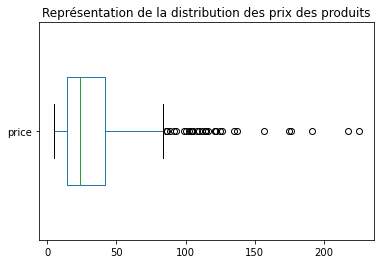

In [30]:
# Représentation en boîte à moustache des valeurs de la colonne 'price'
df_erp_web.boxplot(column='price', vert = False, widths=0.5)
plt.grid(False)
plt.title("Représentation de la distribution des prix des produits")
plt.show()

Sur ce graphique, les outliers sont indiqués par des cercles noirs, on observe que plusieurs valeurs entre 80 et 250 environ sont considérées comme tels.  
Pour afficher graphiquement les outliers, la fonction boxplot a utilisé la méthode de l'intervalle interquartile. Pour obtenir la liste de ces outliers, nous devons appliquer manuellement cette méthode.

###  Méthode intervalle interquartile <a class="anchor" id="section_4_1"></a>

In [31]:
# Calcul de l'intervalle interquartile et des limites hautes et basses
Q1 = df_erp_web['price'].quantile(0.25)
Q3 = df_erp_web['price'].quantile(0.75)

IQR = Q3 - Q1

lower_limit = Q1 - 1.5*IQR
upper_limit = Q3 + 1.5*IQR

lower_limit, upper_limit

# On ne sélectionne que les lignes qui ont une valeur 'price' inférieure à la limite basse ou supérieure à la limite haute
erp_outliers = df_erp_web.loc[(df_erp_web['price'] < lower_limit) | (df_erp_web['price'] > upper_limit)]

# Nombre d'outliers 
nbr_outliers = erp_outliers.shape[0]

# Valeurs min et max de la liste des outliers
minimum = erp_outliers['price'].min()
maximum = erp_outliers['price'].max()


print("Il y a", nbr_outliers, "outliers dans la colonne 'price'. Les prix vont de", minimum, "€ à", maximum, "€")

Il y a 32 outliers dans la colonne 'price'. Les prix vont de 85.6 € à 225.0 €


In [32]:
# On affiche la liste des prix considérés comme des outliers
erp_outliers['price']

63     100.0
65      88.4
200    225.0
202    126.5
206     85.6
219    176.0
220    108.5
222    157.0
223    104.0
229    109.6
386    102.3
387    137.0
434    217.5
439    105.0
440    105.0
447    112.0
448     86.8
514     92.0
524    124.8
566    175.0
601    191.3
616     93.0
617    122.0
618    114.0
661    135.0
666    105.6
667    116.4
672    115.0
673    121.0
674     99.0
675    115.0
676    121.0
Name: price, dtype: float64

Dans notre contexte, bien que ces valeurs soient considérées comme des outliers, elles ne sont pas aberrantes et ne nécessitent pas d'intervention. 

### Méthode z-score <a class="anchor" id="section_4_2"></a>

On peut également utiliser la méthode du z-score pour détecter des outliers.

In [33]:
# On fait une copie du dataframe df_erp_web pour travailler dessus
erp_zscore = df_erp_web.copy()

# On ajoute une colone 'z_score_price' qui calcule le z_score pour chaque prix
erp_zscore['z_score_price'] = (erp_zscore.price - erp_zscore.price.mean())/erp_zscore.price.std()

# On affiche l'identifiant du produit, son prix et le z-score associé
erp_zscore[['product_id', 'price', 'z_score_price']].head(5)

,product_id,price,z_score_price
0,3847,24.2,-0.298201
1,3849,34.3,0.064970
2,3850,20.8,-0.420457
3,4032,14.1,-0.661373
4,4039,46.0,0.485674


In [34]:
# On selectionne que les lignes qui ont un z-score inférieur à -2 ou supèrieur à 2
erp_zscore_outliers = erp_zscore.loc[(erp_zscore['z_score_price'] < -2) | (erp_zscore['z_score_price'] > 2)]

# Nombre d'outliers 
nbr_outliers = erp_zscore_outliers.shape[0]

# Valeurs min et max de la liste des outliers
minimum = erp_zscore_outliers['price'].min()
maximum = erp_zscore_outliers['price'].max()

print("Il y a", nbr_outliers, "outliers dans la colonne 'price'. Les prix vont de", minimum, "€ à", maximum, "€")

Il y a 30 outliers dans la colonne 'price'. Les prix vont de 88.4 € à 225.0 €


In [35]:
# On affiche la liste des prix considérés comme des outliers
erp_zscore_outliers['price']

63     100.0
65      88.4
200    225.0
202    126.5
219    176.0
220    108.5
222    157.0
223    104.0
229    109.6
386    102.3
387    137.0
434    217.5
439    105.0
440    105.0
447    112.0
514     92.0
524    124.8
566    175.0
601    191.3
616     93.0
617    122.0
618    114.0
661    135.0
666    105.6
667    116.4
672    115.0
673    121.0
674     99.0
675    115.0
676    121.0
Name: price, dtype: float64

D'après la méthode du z-score avec un seuil de 2, il y a 30 outliers identifiés dans la colonne 'price'. Ici également, ces prix ne sont pas aberrants dans notre contexte.

## Conclusion <a class="anchor" id="chapter5"></a>

- Nous avons observé certaines anomalies lors du nettoyage des données (produits en vente sur le site sans id_web, produits avec id_web mais non vendus sur le site, produits dans web sans sku).  

- L'analyse de la variable 'price' a permis d'identifier des outliers mais ces valeurs ne sont pas aberrantes et n'ont pas été supprimées.
 